# 

In this iPython notebook we implement a Q-Network algorithm that solves the FrozenLake problem. A nice article to  learn more on the topic: https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0

# Requirements

This code will require the gym enviroment (https://gym.openai.com/) to be installed.

In [20]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,8)

%matplotlib inline

### Load the environment

In [21]:
env = gym.make('FrozenLake-v0')

In [22]:

n_actions = env.action_space.n
n_states = env.observation_space.n

# Actions are left, up, right, down
print(f'Number of actions {n_actions}')
# States are the 16 fields
print(f'Number of possible states {n_states}')

Number of actions 4
Number of possible states 16


The enviroment looks at the start:

In [23]:
env.render()


SFFF
FHFH
FFFH
HFFG


In [24]:
env.reset()
env.step(1)
env.step(2)

(0, 0.0, False, {'prob': 0.3333333333333333})

In [25]:
env.render()

  (Right)
SFFF
FHFH
FFFH
HFFG


## Solving using a Q-Network 

### Network implementation

In [26]:
# Clears the default graph stack and resets the global default graph.
# Useful during the testing phase while I experiment in jupyter notebook.
tf.reset_default_graph()

In [27]:
#  Creating a placeholder for the inputs
inputs = tf.placeholder(shape=[1,n_states],dtype=tf.float32)


In [28]:
# Creating the initial weights as a small randomized matrix
# In this simple example we will use only one set of weights
mean = 0
std = 0.01
init_weights = tf.random_uniform([n_states, n_actions], mean, std)


In [29]:
# Visualizing the initial weights
with tf.Session() as sess_test:
    print(init_weights.eval())

[[0.0091045  0.00994882 0.00258368 0.00716688]
 [0.00830885 0.00863225 0.00993374 0.00380914]
 [0.00367674 0.00839159 0.00927766 0.00107243]
 [0.00236856 0.00051677 0.00685146 0.00173089]
 [0.00430408 0.00628847 0.00988992 0.00263452]
 [0.00183048 0.00144256 0.00959374 0.00954259]
 [0.00075285 0.00165774 0.00211519 0.0010621 ]
 [0.00398035 0.00594413 0.00964837 0.00286101]
 [0.00729633 0.00671199 0.00778714 0.00154243]
 [0.00072523 0.00407604 0.00610985 0.00743805]
 [0.0072149  0.00716246 0.00957782 0.00265761]
 [0.0082889  0.00595119 0.00579262 0.00064036]
 [0.00987939 0.0077068  0.00661001 0.00599952]
 [0.0044199  0.00936864 0.00350829 0.00263951]
 [0.00659144 0.00515254 0.00092156 0.00288359]
 [0.00725825 0.00075709 0.00030617 0.00584852]]


In [30]:
weights = tf.Variable(init_weights)

# Matrix product of two arrays
q_out = tf.matmul(inputs, weights)
predict = tf.argmax(q_out, 1)

In [31]:
# We calculate the loss
# by taking the sum of squares difference between the target and prediction Q values.
next_q = tf.placeholder(shape=[1, n_actions],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(next_q - q_out))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
update_model = trainer.minimize(loss)

### Training the network

In [32]:
init = tf.global_variables_initializer()

# Set learning parameters
y = .99
epsilon = 0.3
num_episodes = 1000
epsilon_decay = 0.999
max_steps = 20

# To keep track of the trainig hisotry
step_list = []
reward_list = []
success = 0


def epsilon_greedy(predict, q_out, s, epsilon):
    a, q_matrix = sess.run([predict, q_out],
                           feed_dict={inputs: np.identity(n_states)[s:s + 1]})
    if np.random.rand(1) < epsilon:
        a[0] = env.action_space.sample()
    return a, q_matrix


with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        total_reward = 0
        done = False

        for step in range(max_steps):
            # Choose an action using epsilon greedy using the Q-network
            a, q_matrix = epsilon_greedy(predict, q_out, s, epsilon)
            # Receive new state and reward from environment
            s_prime, reward, done, _ = env.step(a[0])
            # Calculate Q' using the network
            q_prime = sess.run(
                q_out,
                feed_dict={inputs: np.identity(n_states)[s_prime:s_prime + 1]})
            # Obtain max_q_prime and set our target value for chosen action.
            max_q_prime = np.max(q_prime)
            target_q = q_matrix
            target_q[0, a[0]] = reward + y * max_q_prime
            # Train our network using target and predicted Q values
            _, w_prime = sess.run([update_model, weights],
                                  feed_dict={
                                      inputs: np.identity(n_states)[s:s + 1],
                                      next_q: target_q
                                  })
            total_reward = total_reward + reward
            s = s_prime
            # As we train the model reduces epsilon to reduce the random actions
            epsilon = epsilon * epsilon_decay
            if done == True:
                break

        step_list.append(step)
        reward_list.append(total_reward)

print("Percent of succesful episodes: " + str((sum(reward_list) * 100) / num_episodes) +
      "%")

Percent of succesful episodes: 2.2%


### Some statistics on network performance

We can see that the network beings to consistly reach the goal around the 300 episode mark.

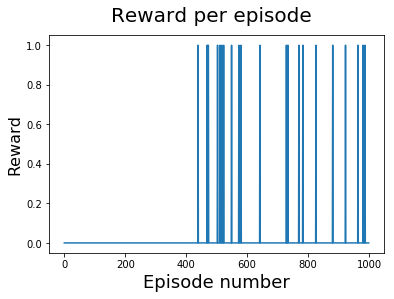

In [33]:
fig = plt.figure()
plt.plot(reward_list)
fig.suptitle('Reward per episode', fontsize=20)
plt.xlabel('Episode number', fontsize=18)
plt.ylabel('Reward', fontsize=16)

plt.show()

It also begins to progress through the environment for longer than chance aroudn the 750 mark as well.

Text(0, 0.5, 'Number of steps')

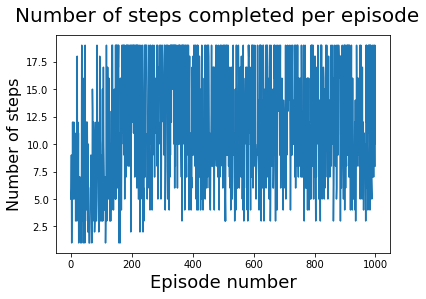

In [34]:
fig = plt.figure()
plt.plot(step_list)
fig.suptitle('Number of steps completed per episode', fontsize=20)
plt.xlabel('Episode number', fontsize=18)
plt.ylabel('Number of steps', fontsize=16)